# Role of dropout rate on uncertainty estimation in classification

[Yarin Gal and Zoubin Ghahramani](https://arxiv.org/abs/1506.02142) introduced inference-time Dropout as a way to 
estimate uncertainty in deep neural networks. Based on Bayesian neural networks -- where weights are 
distributions instead of fixed weights -- they see Dropout as a Bernoulli distribution over weights, i.e. either `w` or `0`. 

If Dropout is used during the forward pass of a trained model at inference time,
one obtains different probabilities on every pass. If this is repeated, one
obtained a distribution of probabilities. The standard deviation of these distributions
can be interpreted as a measure of model uncertainty.

This can be seen as an ensemble approach where each forward pass evaluates
a slightly different model. 


# Data

First, we generate some simple but partly ambiguous data. 

We make two classes by sampling from 2 different 2D multivariate
normal distributions. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [23]:
from sklearn import datasets
X, Y = datasets.make_blobs(n_samples=10000, n_features=2, centers=2, cluster_std=0.5, center_box=(-2, 2), random_state=27)

Plot the data, with the color indicating the class

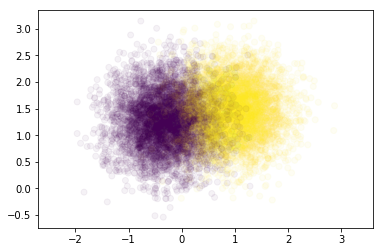

In [24]:
fig, ax = plt.subplots(1,)
ax.scatter(X[:,0],X[:,1],c=Y,alpha=0.05)
_ = ax.axis('equal')

Split the data in a train and test set

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

# Network

We construct a simple classifier NN with Dropout.

With the `training` flag, Dropout is not only executed at training time, but also at inference time. 

In [29]:
def nn_model(dropout_rate, hidden_units=128):
    from keras import layers, models
    
    i = layers.Input((2,))
    x = layers.Dense(units=hidden_units, activation='relu')(i)
    x = layers.Dropout(rate=dropout_rate)(x, training=True) # <== dropout
    o = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs=i, outputs=o)
    

In [30]:
num_hidden_units = 128
model = nn_model(dropout_rate=0.5, hidden_units=num_hidden_units)
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train network

CPU times: user 5.24 s, sys: 487 ms, total: 5.72 s
Wall time: 3.25 s


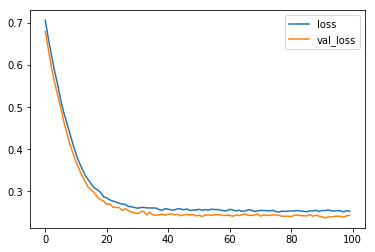

In [31]:
%%time

batch_size = 1024
epochs = 100

history = model.fit(X_train, Y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

fig, ax = plt.subplots(1,)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()

# Prediction 

Due to inference-time Dropout, we get a difference prediction every time we do a forward pass.

Here, we do it `T=3` times and get slightly different predictions (indicated by colors):

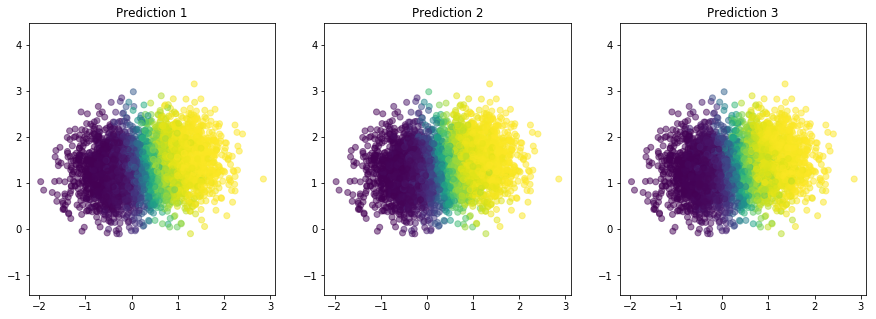

In [36]:
T = 3
fig, ax = plt.subplots(1,T,figsize=(T*5,5))

for i in range(T):
    
    # predict
    y_pred = np.squeeze(model.predict(X_test))
    
    # plot
    ax[i].scatter(X_test[:,0], X_test[:,1], c=y_pred, alpha=0.5, cmap='viridis')
    ax[i].set_title('Prediction {}'.format(i+1))
    _ = ax[i].axis('equal')

Let's split the data set in ambiguous data points, where `x` coordinate is between `(-r, r)`, and non-ambiguous data points. 

In [37]:
r = 0.5
X_ambiguous = X_test[ (X_test[:,0] > -r) & (X_test[:,0] < r) ]
X_nonambiguous = X_test[ (X_test[:,0] <= -2*r) | (X_test[:,0] >= 2*r) ]
X_ambiguous.shape

(1278, 2)

If we now predict the class probabilities of `sample=0` a `n=1000` times and plot the histograms, 
we can fit them with a normal distribution. 

The standard deviation of the fitted normal distribution is the epistemic uncertainty. 

The probability for class 0 = 0.43 +/- 0.07


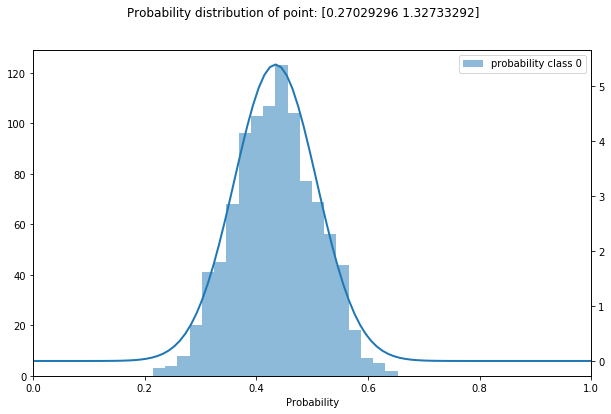

In [38]:
n = 1000
sample = 0
data_sample = X_ambiguous[sample][np.newaxis, ...]

# predict the class probabilities of the `sample`
# by performing `n` forward passes with dropout
probs = np.array([model.predict(data_sample)[0] for i in range(n)])

fig, ax = plt.subplots(figsize=(10,6))

# plot the histograms of the probabilities
fig.suptitle('Probability distribution of point: {}'.format(X_ambiguous[:1][0]))
_ = ax.hist(probs[:,0], bins=20, alpha=0.5, label='probability class 0')
ax.set_xlabel('Probability')
#_ = ax.hist(probs[:,1], bins=20, alpha=0.5, label='probability class 1')
_ = ax.legend()
_ = plt.legend(loc='best')
ax.set_xlim([0.,1.])

# fit a normal distribution and plot them
ax2 = ax.twinx()
from scipy.stats import norm
for i in range(1):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(probs[:,i])
    print('The probability for class {} = {:.2f} +/- {:.2f}'.format(i, mu, std))
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(x, p, linewidth=2)

We can now repeat this for all the test sample (`X_test`) and plot the probabilities *and* uncertainties as a scatter plot.

In [39]:
%%time
n = 100
probs = np.squeeze(np.array([model.predict(X_test) for i in range(n)]))



CPU times: user 3.97 s, sys: 551 ms, total: 4.53 s
Wall time: 3.04 s


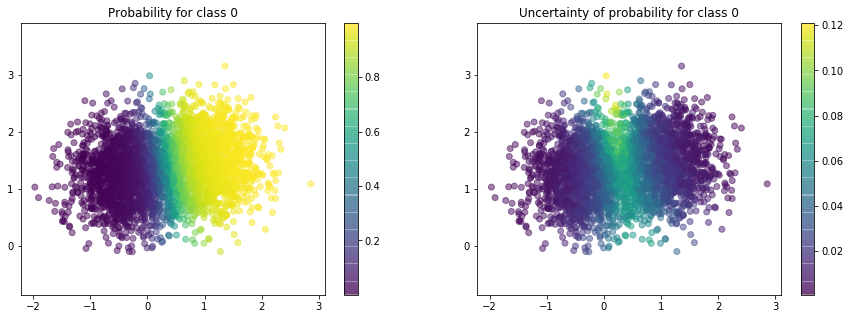

In [42]:
prob_class0_mean = np.mean(probs, axis=0)
prob_class0_std = np.std(probs, axis=0)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Probability for class 0')
cax0 = ax[0].scatter(X_test[:,0],X_test[:,1],c=prob_class0_mean,alpha=0.5)
_ = ax[0].axis('equal')
plt.colorbar(cax0, ax=ax[0])

ax[1].set_title('Uncertainty of probability for class 0')
cax1 = ax[1].scatter(X_test[:,0],X_test[:,1],c=prob_class0_std,alpha=0.5)
_ = ax[1].axis('equal')
plt.colorbar(cax1, ax=ax[1])

As expected, we see that ambiguous data points between the two clusters have highest uncertainty.
